# When is the optimum point to be born for the Olympics?

I am going to analyse when is the best point in the 4-year Olympiad to have the greatest chance of competing (or medaling) at the olympics.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
pd.set_option('display.max_rows', None) # Display full dataframe tables
pd.set_option('display.max_columns', None)

In [3]:
from scipy.stats import chisquare
from scipy.stats import binom

In [4]:
# Read in data
athlete_df=pd.read_csv("data/athlete_events.csv",index_col="ID")
noc_df=pd.read_csv("data/noc_regions.csv",index_col="NOC")

**Limitations**\
The only age data is in years only. This means we cannot tell whether two people were born 2 months apart or 23 months apart. This is a big limitation on the analysis.\
Athletes who compete in multiple events/games have multiple entries in the dataset. This could affect analysis due to multiple counting of same competitor. It is hard to remove as names are the only unique identifiers.

# Data Cleaning

In [5]:
noc_df=noc_df.reset_index()
noc_df["NOC"]=noc_df["NOC"].str.lower()
noc_df.columns=["NOC","Region","Notes"]

In [6]:
# drop unnecesary columns
athlete_df=athlete_df.drop(["Height","Weight","Team","Games","City"],axis=1)

In [7]:
# strips event string to remove reference to gender and sport
def clean_event(row):
    event=row["Event"]; sport=row["Sport"]
    event=event.replace(sport,"")
    event=event.replace("women's","")
    event=event.replace("men's","")
    event=event.strip()
    return event if event!="" else np.NaN

In [8]:
# drop rows without age data
print("{:,} rows without age values removed.".format(athlete_df["Age"].isnull().sum()))
athlete_df=athlete_df[athlete_df["Age"].notnull()].reindex()

9,474 rows without age values removed.


### Drop big team sports, sports with little data or are non-physical

In [9]:
# count number of olympic games each sport has appeared at
def games_per_sport(df):
    sport_years_df=pd.pivot_table(data=athlete_df,values="Year",index="Sport",aggfunc=[lambda x:len(list(x.unique()))])
    sport_years_df.columns=["Num_Years"]
    sport_years_df["Num_Years"]=sport_years_df["Num_Years"].astype(int)
    return sport_years_df

In [10]:
# remove big team sports & non-physical sports
non_physical=["Art Competitions","Equestrianism","Polo","Sailing"]
team_sports=["Baseball","Tug-Of-War","Handball","Basketball","Ice Hockey","Hockey","Football","Water Polo"]
athlete_df=athlete_df[~athlete_df["Sport"].isin(non_physical)]
athlete_df=athlete_df[~athlete_df["Sport"].isin(team_sports)]

In [11]:
# remove sports which appeared in less than 10 games
games_per_sport_df=games_per_sport(athlete_df)
common_sports=games_per_sport_df[games_per_sport_df["Num_Years"]>=10]

print("{:,} rows removed due to sport.".format((~athlete_df["Sport"].isin(common_sports.index)).sum()))
athlete_df=athlete_df[athlete_df["Sport"].isin(common_sports.index)]

12,160 rows removed due to sport.


## Standardise Data

In [12]:
# make all strings lowercase
athlete_df[["Name","Season","NOC","Sport","Event","Medal"]]=athlete_df[["Name","Season","NOC","Sport","Event","Medal"]].astype(str)
for col in ["Name","Season","NOC","Sport","Event","Medal"]:
    athlete_df[col]=athlete_df[col].str.lower()
    athlete_df[col]=athlete_df[col].replace("nan",np.NaN)

In [13]:
# Add Fields
athlete_df["Cycle_Age"]=(athlete_df["Age"]%4).astype(int) # Age wrt point in olympic cycle
athlete_df["Medalist"]=athlete_df["Medal"].isin(["gold","silver","bronze"]) # boolean for whether athlete won a medal

In [14]:
male_athletes=athlete_df[athlete_df["Sex"]=="M"].copy()
female_athletes=athlete_df[athlete_df["Sex"]=="F"].copy()

# Overview Analysis

In [15]:
print("'athlete_df' contains {:,} rows covering:".format(athlete_df.shape[0]))
summer_games=athlete_df[athlete_df["Season"]=="summer"]
winter_games=athlete_df[athlete_df["Season"]=="winter"]
print("\t{} summer games ({}-{}) & {} winter games ({}-{}).".format(len(summer_games["Year"].unique()),summer_games["Year"].min(),summer_games["Year"].max(),len(winter_games["Year"].unique()),winter_games["Year"].min(),winter_games["Year"].max()))
print("\t{} sports ({} summer, {} winter).".format(len(athlete_df["Sport"].unique()),len(athlete_df[athlete_df["Season"]=="summer"]["Sport"].unique()),len(athlete_df[athlete_df["Season"]=="winter"]["Sport"].unique())))

both_games_sports=list(set(athlete_df[athlete_df["Season"]=="summer"]["Sport"].unique()) & set(athlete_df[athlete_df["Season"]=="winter"]["Sport"].unique()))
print("\t{} sport{} have appeared in both winter & summer games ({})".format(len(both_games_sports),"" if len(both_games_sports)==1 else "s",",".join(both_games_sports)))
print("\t{} events ({} summer, {} winter).\n".format(len(athlete_df["Event"].unique()),len(athlete_df[athlete_df["Season"]=="summer"]["Event"].unique()),len(athlete_df[athlete_df["Season"]=="winter"]["Event"].unique())))


'athlete_df' contains 204,151 rows covering:
	29 summer games (1896-2016) & 22 winter games (1924-2014).
	26 sports (18 summer, 9 winter).
	1 sport have appeared in both winter & summer games (figure skating)
	571 events (493 summer, 81 winter).



# Problem Analysis

## Age Distribution of Medalists vs All Competitors

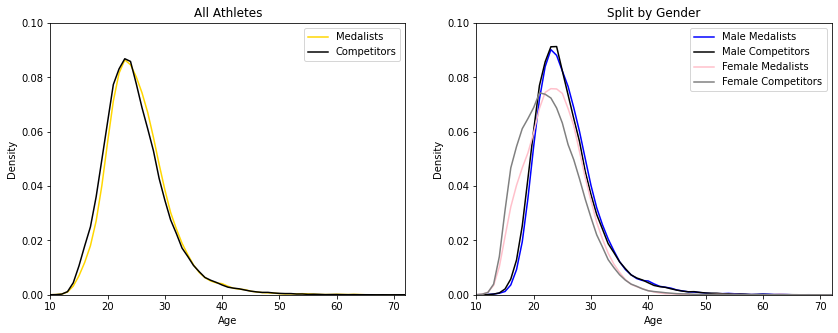

In [16]:
fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=2)
# kde plot of age distribution for medal winners against non-winners
# suggests medal winners are slightly older
xlims=(athlete_df["Age"].min(),athlete_df["Age"].max())
ylims=(0,.1)
eval_points=[i for i in range(int(xlims[0]),int(xlims[1])+1)] # estimate distribution at each year

# Plot data for all athletes
athlete_df[athlete_df["Medalist"]]["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Medalists",color="gold",ax=axes[0])
athlete_df["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Competitors",color="black",ax=axes[0])
axes[0].set_title("All Athletes")
axes[0].set_xlabel("Age")
axes[0].legend()

# plot male data
male_athletes[male_athletes["Medalist"]]["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Male Medalists",color="blue",ax=axes[1])
male_athletes["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Male Competitors",color="black",ax=axes[1])

# plot female data
female_athletes[female_athletes["Medalist"]]["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Female Medalists",color="pink",ax=axes[1])
female_athletes["Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label="Female Competitors",color="gray",ax=axes[1])
axes[1].set_title("Split by Gender")
axes[1].set_xlabel("Age")
axes[1].legend()

The distribution for men are practically identical. Whereas, the female distributions are notably different and this should be investigated further. Does this discrepency only occur in female dominated sports or does it occur across all sports?

In [17]:
mean_competitor_age=athlete_df["Age"].mean()
mean_medalist_age=athlete_df[athlete_df["Medalist"]]["Age"].mean()

summary_data=pd.DataFrame(columns=["Mean Competitor Age","Mean Medalist Age","Mode Competitor Age","Mode Medalist Age","Competitor Age Quartiles","Medalist Age Quartiles"])

dfs={"all":athlete_df,"male":male_athletes,"female":female_athletes}
for name,df in dfs.items():
    medalists_df=df[df["Medalist"]]
    
    row={}
    row["Mean Competitor Age"]=round(df["Age"].mean(),2)
    row["Mean Medalist Age"]  =round(medalists_df["Age"].mean(),2)
    
    row["Mode Competitor Age"]=int(df["Age"].mode())
    row["Mode Medalist Age"]  =int(medalists_df["Age"].mode())

    row["Competitor Age Quartiles"]=(int(df["Age"].quantile(.25)),int(df["Age"].quantile(.50)),int(df["Age"].quantile(.75)))
    row["Medalist Age Quartiles"]=(int(medalists_df["Age"].quantile(.25)),int(medalists_df["Age"].quantile(.50)),int(medalists_df["Age"].quantile(.75)))
    
    series=pd.Series(row)
    series.name=name
    
    summary_data=summary_data.append(series)

summary_data

,Mean Competitor Age,Mean Medalist Age,Mode Competitor Age,Mode Medalist Age,Competitor Age Quartiles,Medalist Age Quartiles
all,24.88,25.36,23,23,"(21, 24, 28)","(22, 25, 28)"
male,25.59,25.94,24,23,"(22, 25, 28)","(22, 25, 28)"
female,23.12,23.94,21,25,"(19, 23, 26)","(20, 24, 27)"


- Medalists are, on average, six months older than competitors.
    - For men they are four months older
    - for women they are ten months older.
- Female competitors are, on average, 2 years 6 months younger than male.
- Female medalists are, on average, 2 years younger than male.

## Normalised Age Distribution

Considering the age distribution when ages are normalised to when the athlete was born during an olympiad.

In [18]:
competitors_cycle_ages_counts=athlete_df["Cycle_Age"].value_counts(normalize=True).sort_index()
medalist_cycle_ages_counts=athlete_df[athlete_df["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()

male_competitors_cycle_ages_counts=male_athletes["Cycle_Age"].value_counts(normalize=True).sort_index()
male_medalist_cycle_ages_counts=male_athletes[male_athletes["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()

female_competitors_cycle_ages_counts=female_athletes["Cycle_Age"].value_counts(normalize=True).sort_index()
female_medalist_cycle_ages_counts=female_athletes[female_athletes["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()

# merge data
cycle_age_counts=pd.concat([competitors_cycle_ages_counts,medalist_cycle_ages_counts,male_competitors_cycle_ages_counts,female_competitors_cycle_ages_counts,male_medalist_cycle_ages_counts,female_medalist_cycle_ages_counts],axis=1)
cycle_age_counts.columns=["All Competitors","All Medalists","Male Competitors","Female Competitors","Male Medalists","Female Medalists"]
cycle_age_counts

,All Competitors,All Medalists,Male Competitors,Female Competitors,Male Medalists,Female Medalists
0,0.255487,0.252528,0.256030,0.254136,0.254165,0.248446
1,0.247787,0.248438,0.247187,0.249282,0.247214,0.251488
2,0.246097,0.249006,0.246431,0.245266,0.249124,0.248710
3,0.250628,0.250028,0.250352,0.251316,0.249496,0.251356


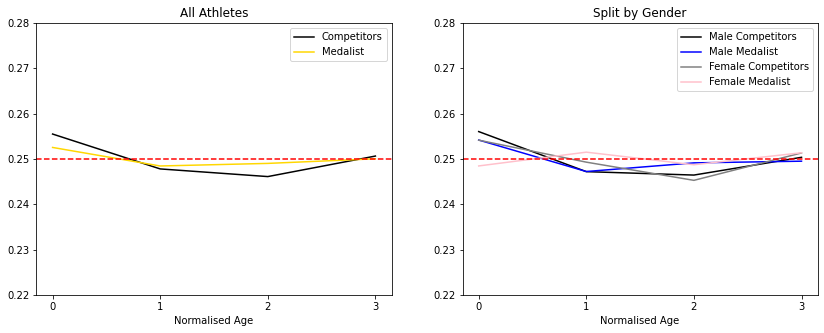

In [19]:
# Visualise results
fig,axes=plt.subplots(figsize=(14,5),ncols=2,nrows=1)
y_lims=(.22,.28)
y_tick_labels=[x/100 for x in range(int(100*y_lims[0]),int(100*y_lims[1])+1,1)]
x_tick_labels=range(0,4)

# plot data for all athletes
cycle_age_counts["All Competitors"].plot(color="black",label="Competitors",ylim=y_lims,ax=axes[0])
cycle_age_counts["All Medalists"].plot(color="gold",label="Medalist",ylim=y_lims,ax=axes[0])
axes[0].axhline(.25,color="red",ls="--")
axes[0].set_xlabel("Normalised Age")
axes[0].set_xticks(x_tick_labels)
axes[0].set_yticks(y_tick_labels)
axes[0].set_title("All Athletes")
axes[0].legend()

# plot data split by gender
cycle_age_counts["Male Competitors"].plot(color="black",label="Male Competitors",ylim=y_lims,ax=axes[1])
cycle_age_counts["Male Medalists"].plot(color="blue",label="Male Medalist",ylim=y_lims,ax=axes[1])
cycle_age_counts["Female Competitors"].plot(color="gray",label="Female Competitors",ylim=y_lims,ax=axes[1])
cycle_age_counts["Female Medalists"].plot(color="pink",label="Female Medalist",ylim=y_lims,ax=axes[1])
axes[1].axhline(.25,color="red",ls="--")
axes[1].set_xlabel("Normalised Age")
axes[1].set_xticks(x_tick_labels)
axes[1].set_yticks(y_tick_labels)
axes[1].set_title("Split by Gender")
axes[1].legend()

There is a discrepancy which suggests being born in an olympic year increases the probability of competing and of medaling. The discrepancy exists in all categories, except for female medalists. Suggests that medalists are much more uniformly distributed, whereas competitors are not. Are any of these discrepancies statistically significant?

## Hypothesis Testing

### HYPOTHEIS TEST for probability of binomial RV modelling whether a *medalist* was born in an olympic year.

It has been observed that the probability that an olympic *medalist* was born in an olympic is higher than the expected. Here I perform a hypothesis test to determine whether this value was statistically significant.

Let $X\sim \text{Binom}(n,p)$ model the number of medalists who were born in an olympiad.\
$H_0:p=.25$\
$H_1:p>.25$\
Significance Level: 10%\
It has been observed that out of 36,283 medalists, 9,158 were born in an olympiad.

In [20]:
from scipy.stats import binom

In [21]:
n=athlete_df[athlete_df["Medalist"]].shape[0] # medal winner
obs=athlete_df[athlete_df["Medalist"] & (athlete_df["Cycle_Age"]==0)].shape[0] # medal winner and born in olympiad
print("Num medal winners: {:,}. Num medal winners born in olympiad: {:,} (p={:.4f}).".format(n,obs,obs/n))

expected_p=1/4
p_value=1-binom.cdf(obs,n,expected_p) # H0:p=1/4, H1:p!=1/4
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Num medal winners: 26,405. Num medal winners born in olympiad: 6,668 (p=0.2525).
p_value=0.16957065. *Not* Statistically Significant



There is **no evidence** that more olympic medalists were born in an olympic year.

### HYPOTHEIS TEST for probability of binomial RV modelling whether a *competitor* was born in an olympic year.

It has been observed that the probability that an olympic *competitor* was born in an olympic is higher than the expected. Here I perform a hypothesis test to determine whether this value was statistically significant.

Let $X\sim \text{Binom}(n,p)$ model the number of medalists who were born in an olympiad.\
$H_0:p=.25$\
$H_1:p>.25$\
Significance Level: 10%\
It has been observed that out of 245,302 medalists, 62,487 were born in an olympiad.

In [22]:
n=athlete_df.shape[0] # competitor
obs=(athlete_df["Cycle_Age"]==0).sum() # competitor and born in olympiad
print("Num competitors: {:,}. Num competitors born in olympiad: {:,} (p={:.4f}).".format(n,obs,obs/n))

expected_p=1/4
p_value=1-binom.cdf(obs,n,expected_p) # H0:p=1/4, H1:p!=1/4
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Num competitors: 204,151. Num competitors born in olympiad: 52,158 (p=0.2555).
p_value=0.00000001. Statistically Significant



There is *sufficient evidence* that more olympic competitors were born in an olympic year.

### $\chi^2$ TEST for whether distribution of *medalists* ages in olympic cycle is uniform.

Here I use a chi-squared test to determine whether the distribution of normalised ages for olympic *medalists* follows a uniform distribution. It is expected that a quarter of all medalists will be born in each year.

$dof=3$

In [23]:
f_obs=athlete_df[athlete_df["Medalist"]]["Cycle_Age"].value_counts().sort_index().values
f_exp=np.repeat(sum(f_obs)/4,4)
print("Observed occs: {}. Expected occs: {}".format(f_obs,f_exp))
_,p_value=chisquare(f_obs,f_exp)
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Observed occs: [6668 6560 6575 6602]. Expected occs: [6601.25 6601.25 6601.25 6601.25]
p_value=0.79225410. *Not* Statistically Significant



There is **no evidence** that the distribution of when olympic medalists where, born in an olympiad, is not uniform. This suggests that the year you are born does not affect the probability of you winning an olympic medal.

### $\chi^2$ TEST for whether distribution of *competitors* ages in olympic cycle is uniform.

Here I use a chi-squared test to determine whether the distribution of normalised ages for olympic *competitors* follows a uniform distribution. It is expected that a quarter of all competitors will be born in each year.

$dof=3$

In [24]:
f_obs=athlete_df["Cycle_Age"].value_counts().sort_index().values
f_exp=np.repeat(sum(f_obs)/4,4)
print("Observed occs: {}. Expected occs: {}".format(f_obs,f_exp))
_,p_value=chisquare(f_obs,f_exp)
print("p_value={:.8f}. {}Statistically Significant\n".format(p_value,"" if p_value<=.1 else "*Not* "))

Observed occs: [52158 50586 50241 51166]. Expected occs: [51037.75 51037.75 51037.75 51037.75]
p_value=0.00000001. Statistically Significant



There is **sufficient evidence** that the distribution of when olympic athletes, where born in an olympiad, is **not** uniform. This suggests that being born at the start of an olympiad means you are more likely to compete in an olympics.

### Summary

| Test | Result |
|:-----|:-------|
| More *medalists* are born in olympic years | False |
| More *competitors* are born in olympic years | True |
| The distribution of normalised ages of *medalists* is uniform | True |
| The distribution of normalised ages of *competitors* is uniform | False |

## Age Distribution Split By Sport

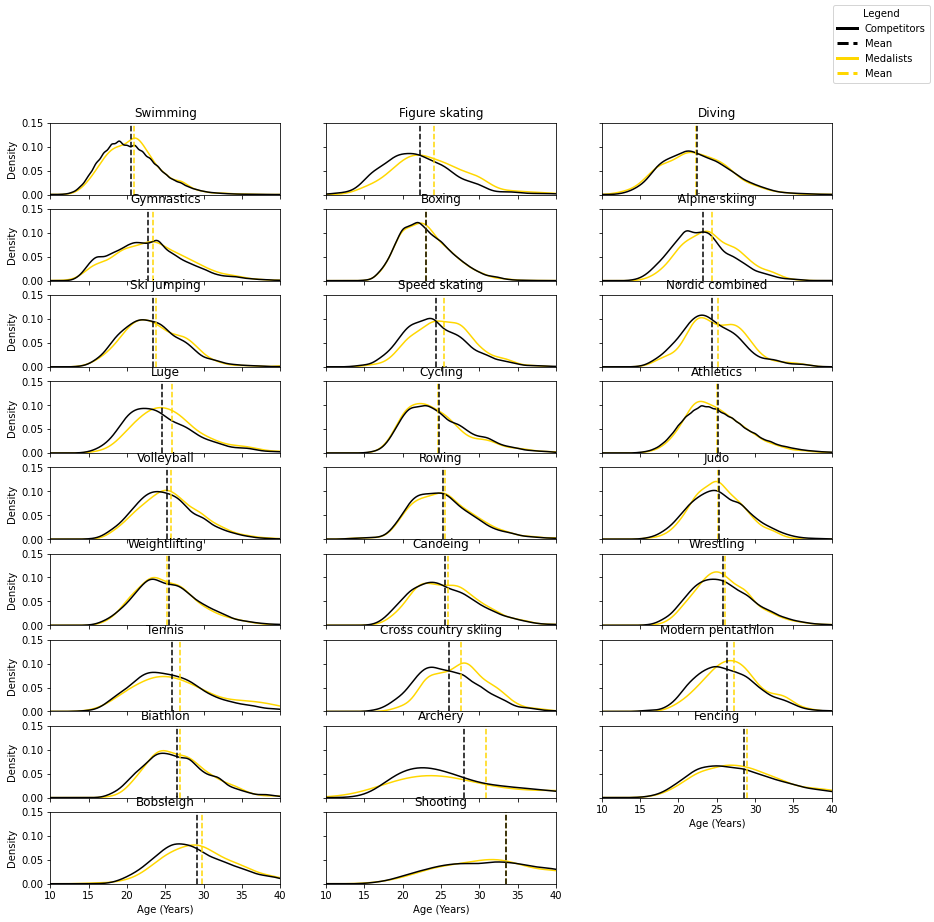

In [25]:
# sort sports by mean age increasing
mean_age_per_sport=athlete_df.groupby(by=["Sport"])["Age"].mean().sort_values()
num_sports=mean_age_per_sport.shape[0]

# plot of age distribution for each sports
fig,axes=plt.subplots(figsize=(14,14),ncols=3,nrows=int(np.ceil(num_sports/3)))

# ensure plots are all same scale
xlims=(athlete_df["Age"].min(),40)
ylims=(0,.15)

means=pd.DataFrame(columns=["Mean Competitor Age","Mean Medalist Age"]) # calculate mean age for each sport & category

for count,sport in enumerate(list(mean_age_per_sport.index)):
    print("({}/{}) {}                ".format(count,len(mean_age_per_sport),sport),end="\r",flush=True)
    row_i=count//3; col_i=count%3
    ax=axes[row_i,col_i]
    data=athlete_df[athlete_df["Sport"]==sport]

    # plot data
    data[data["Medalist"]]["Age"].plot.kde(ax=ax,xlim=xlims,ylim=ylims,label="Medalists",color="gold")
    data["Age"].plot.kde(ax=ax,xlim=xlims,ylim=ylims,label="Competitors",color="black")
    
    # add horizontal line for mean of each
    series=pd.Series({"Mean Competitor Age":data["Age"].mean(),"Mean Medalist Age":data[data["Medalist"]]["Age"].mean()})
    series.name=sport
    series=series.apply(lambda x:round(x,2)) # round due to data only being accurate to years
    means=means.append(series)
    
    ax.axvline(x=data[data["Medalist"]]["Age"].mean(),color="gold",ls="--")
    ax.axvline(x=data["Age"].mean(),color="black",ls="--")

    # style plot
    ax.set_title(str.capitalize(sport))
    ax.set_yticks([0,.05,.1,.15])
    if (col_i==0): ax.set_ylabel("Density") # LHS
    else: ax.set_ylabel(""); ax.set_yticklabels([])
    if (count+3>=num_sports): ax.set_xlabel("Age (Years)") # bottom of each column
    else: ax.set_xlabel(""); ax.set_xticklabels([])

# remove excess plots
for i in range(num_sports,3*int(np.ceil(num_sports/3))):
    row_i=i//3; col_i=i%3
    fig.delaxes(axes[row_i,col_i])

# legend data
from matplotlib.lines import Line2D
colors=['black',"black",'gold',"gold"]
style =["-","--","-","--"]
lines =[Line2D([0],[0],linewidth=3,linestyle=style[i],color=colors[i]) for i in range(4)]
labels=["Competitors","Mean","Medalists","Mean"]
fig.legend(lines,labels,title="Legend",loc="upper right")

plt.show()

In [26]:
# Some more analysis
means["diff"]=abs(means["Mean Competitor Age"]-means["Mean Medalist Age"])
means["Younger Medalists"]=(means["Mean Competitor Age"]>means["Mean Medalist Age"])
means=means.sort_values("diff")
means.transpose()

,boxing,shooting,judo,athletics,cycling,diving,weightlifting,wrestling,rowing,swimming,fencing,biathlon,ski jumping,canoeing,volleyball,gymnastics,bobsleigh,nordic combined,modern pentathlon,tennis,speed skating,alpine skiing,luge,cross country skiing,figure skating,archery
Mean Competitor Age,23.05,33.42,25.33,25.16,24.77,22.48,25.5,25.8,25.28,20.57,28.54,26.53,23.35,25.5,25.18,22.73,29.11,24.34,26.39,25.85,24.3,23.21,24.63,26.01,22.23,27.94
Mean Medalist Age,23.06,33.45,25.2,25.02,24.6,22.26,25.28,26.08,25.57,20.92,28.9,26.9,23.75,25.96,25.78,23.41,29.85,25.1,27.22,26.89,25.37,24.34,25.82,27.62,24.02,30.93
diff,0.01,0.03,0.13,0.14,0.17,0.22,0.22,0.28,0.29,0.35,0.36,0.37,0.4,0.46,0.6,0.68,0.74,0.76,0.83,1.04,1.07,1.13,1.19,1.61,1.79,2.99
Younger Medalists,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [27]:
print("In {}, out of {}, sports medalists are younger on average than all competitors".format(means["Younger Medalists"].sum(),means.shape[0]))
print("These sports are {}.\n".format(", ".join(means[means["Younger Medalists"]].index)))

print("In {}, out of {}, sports there is >1yr mean age difference between medalists & competitors.".format((means["diff"]>1).sum(),means.shape[0]))
print("These sports are {}.\n".format(", ".join(means[means["diff"]>1].index)))

max_age=means["diff"].max()
min_age=means["diff"].min()
print("The biggests age difference ({}yr {}mth) occurs in {}.".format(int(max_age),int(12*(max_age%1)),", ".join(means[means["diff"]==max_age].index)))
print("The closest age difference  ({}yr {}mth) occurs in {}. ".format(int(min_age),int(12*(min_age%1)),", ".join(means[means["diff"]==min_age].index)))

In 5, out of 26, sports medalists are younger on average than all competitors
These sports are judo, athletics, cycling, diving, weightlifting.

In 7, out of 26, sports there is >1yr mean age difference between medalists & competitors.
These sports are tennis, speed skating, alpine skiing, luge, cross country skiing, figure skating, archery.

The biggests age difference (2yr 11mth) occurs in archery.
The closest age difference  (0yr 0mth) occurs in boxing. 


### Age Distribution split by Sport and Gender

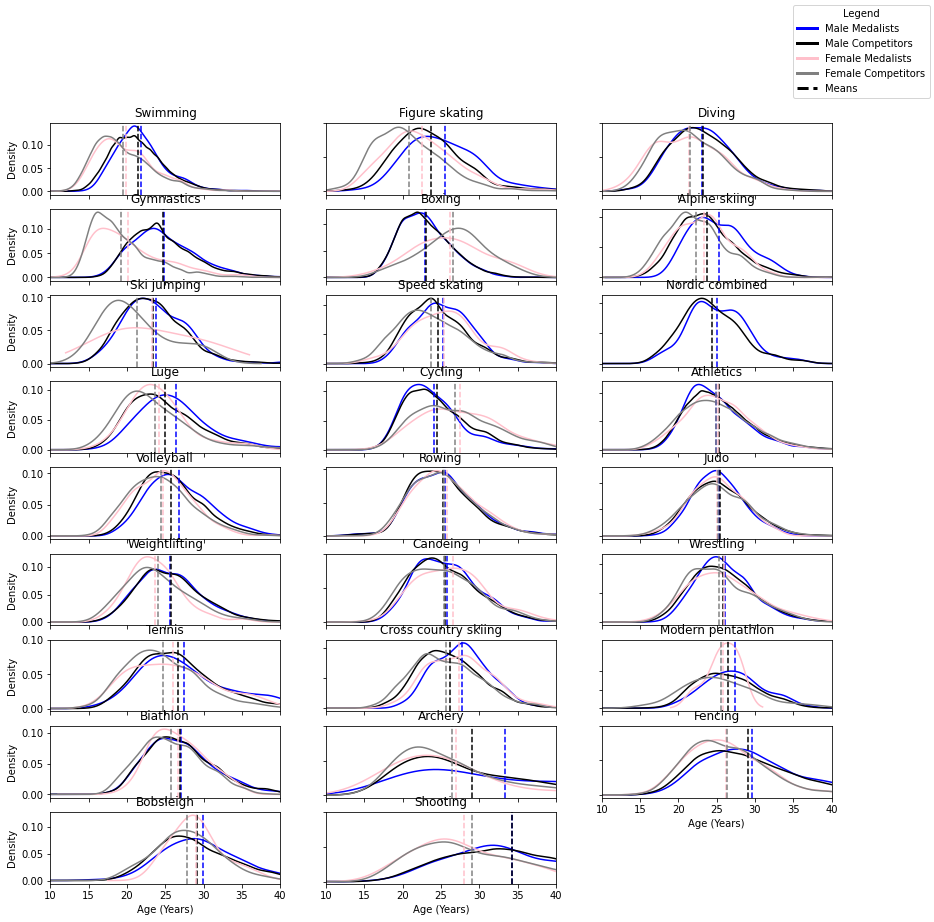

In [28]:
# plot of age distribution for each sports
fig,axes=plt.subplots(figsize=(14,14),ncols=3,nrows=int(np.ceil(num_sports/3)))
ylims=(0,.10)

gendered_means=pd.DataFrame(columns=["Mean Male Competitor Age","Mean Male Medalist Age","Mean Female Competitor Age","Mean Female Medalist Age"])

for count,sport in enumerate(list(mean_age_per_sport.index)):
    print("({}/{}) {}                ".format(count,len(mean_age_per_sport),sport),end="\r",flush=True)
    row_i=count//3; col_i=count%3
    ax=axes[row_i,col_i]
    data=athlete_df[athlete_df["Sport"]==sport]
    male_data=data[data["Sex"]=="M"]
    female_data=data[data["Sex"]=="F"]
    
    row={}
    
    # plot kdes
    if (male_data.shape[0]>0): # male data
        male_data[male_data["Medalist"]]["Age"].plot.kde(ax=ax,xlim=xlims,label="Male Medalists",color="blue")
        male_data["Age"].plot.kde(ax=ax,xlim=xlims,label="Male Competitors",color="black")
    if (female_data.shape[0]>0): # female data
        female_data[female_data["Medalist"]]["Age"].plot.kde(ax=ax,xlim=xlims,label="Female Medalists",color="pink")
        female_data["Age"].plot.kde(ax=ax,xlim=xlims,label="Female Competitors",color="gray")


    # plot mean ages
    if (male_data.shape[0]>0): # male data
        ax.axvline(x=male_data[male_data["Medalist"]]["Age"].mean(),color="blue",ls="--")
        ax.axvline(x=male_data["Age"].mean(),color="black",ls="--")
        row["Mean Male Medalist Age"]=male_data[male_data["Medalist"]]["Age"].mean()
        row["Mean Male Competitor Age"]=male_data["Age"].mean()
    if (female_data.shape[0]>0): # female data
        ax.axvline(x=female_data[female_data["Medalist"]]["Age"].mean(),color="pink",ls="--")
        ax.axvline(x=female_data["Age"].mean(),color="gray",ls="--")
        row["Mean Female Medalist Age"]=female_data[female_data["Medalist"]]["Age"].mean()
        row["Mean Female Competitor Age"]=female_data["Age"].mean()
        
    series=pd.Series(row)
    series.name=sport
    series=series.apply(lambda x:round(x,2))
    gendered_means=gendered_means.append(series)
        
    # style plot
    ax.set_title(str.capitalize(sport))
    ax.set_yticks([0,.05,.1])
    if (col_i==0): ax.set_ylabel("Density") # LHS
    else: ax.set_ylabel(""); ax.set_yticklabels([])
    if (count+3>=num_sports): ax.set_xlabel("Age (Years)") # bottom of each column
    else: ax.set_xlabel(""); ax.set_xticklabels([])

# remove excess plots
for i in range(num_sports,3*int(np.ceil(num_sports/3))):
    row_i=i//3; col_i=i%3
    fig.delaxes(axes[row_i,col_i])

# legend data
from matplotlib.lines import Line2D
colors=['blue',"black",'pink',"gray","black"]
style =["-","-","-","-","--"]
lines =[Line2D([0],[0],linewidth=3,linestyle=style[i],color=colors[i]) for i in range(5)]
labels=["Male Medalists","Male Competitors","Female Medalists","Female Competitors","Means"]
fig.legend(lines,labels,title="Legend",loc="upper right")

plt.show()

### Male Mean Age by Sport

In [29]:
# Male data
male_means=gendered_means[["Mean Male Competitor Age","Mean Male Medalist Age"]].copy()
male_means["diff"]=abs(male_means["Mean Male Competitor Age"]-male_means["Mean Male Medalist Age"])
male_means["Younger Medalists"]=(male_means["Mean Male Competitor Age"]>male_means["Mean Male Medalist Age"])
male_means=male_means.sort_values("diff")
male_means.transpose()

,shooting,biathlon,boxing,weightlifting,judo,diving,canoeing,gymnastics,rowing,wrestling,athletics,cycling,ski jumping,swimming,fencing,speed skating,bobsleigh,nordic combined,tennis,modern pentathlon,volleyball,luge,cross country skiing,alpine skiing,figure skating,archery
Mean Male Competitor Age,34.25,26.98,23.01,25.71,25.4,23.23,25.55,24.65,25.24,25.82,25.26,24.44,23.37,21.38,29.08,24.63,29.17,24.34,26.63,26.49,25.81,24.96,26.21,23.76,23.72,29.08
Mean Male Medalist Age,34.22,27.01,22.98,25.6,25.29,23.08,25.78,24.9,25.5,26.09,24.97,24.12,23.76,21.8,29.58,25.31,29.9,25.1,27.47,27.35,26.78,26.35,27.77,25.34,25.52,33.32
diff,0.03,0.03,0.03,0.11,0.11,0.15,0.23,0.25,0.26,0.27,0.29,0.32,0.39,0.42,0.5,0.68,0.73,0.76,0.84,0.86,0.97,1.39,1.56,1.58,1.8,4.24
Younger Medalists,True,False,True,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [30]:
print("In {}, out of {}, sports male medalists are younger on average than all competitors".format(male_means["Younger Medalists"].sum(),male_means.shape[0]))
print("These sports are {}.\n".format(", ".join(male_means[male_means["Younger Medalists"]].index)))

print("In {}, out of {}, sports there is >1yr mean age difference between male medalists & competitors.".format((male_means["diff"]>1).sum(),male_means.shape[0]))
print("These sports are {}.\n".format(", ".join(male_means[male_means["diff"]>1].index)))

max_age=male_means["diff"].max()
min_age=male_means["diff"].min()
print("The biggests age difference ({}yr {}mth) occurs in {}.".format(int(max_age),int(12*(max_age%1)),", ".join(male_means[male_means["diff"]==max_age].index)))
print("The closest age difference  ({}yr {}mth) occurs in {}. ".format(int(min_age),int(12*(min_age%1)),", ".join(male_means[male_means["diff"]==min_age].index)))

In 7, out of 26, sports male medalists are younger on average than all competitors
These sports are shooting, boxing, weightlifting, judo, diving, athletics, cycling.

In 5, out of 26, sports there is >1yr mean age difference between male medalists & competitors.
These sports are luge, cross country skiing, alpine skiing, figure skating, archery.

The biggests age difference (4yr 2mth) occurs in archery.
The closest age difference  (0yr 0mth) occurs in shooting, biathlon, boxing. 


### Female Mean Age by Sport

In [31]:
# Male data
female_means=gendered_means[["Mean Female Competitor Age","Mean Female Medalist Age"]].copy()
female_means["diff"]=abs(female_means["Mean Female Competitor Age"]-female_means["Mean Female Medalist Age"])
female_means["Younger Medalists"]=(female_means["Mean Female Competitor Age"]>female_means["Mean Female Medalist Age"])
female_means=female_means.sort_values("diff")
female_means.transpose()

,fencing,judo,diving,athletics,modern pentathlon,volleyball,rowing,weightlifting,swimming,archery,boxing,cycling,luge,wrestling,biathlon,gymnastics,alpine skiing,shooting,canoeing,bobsleigh,tennis,figure skating,speed skating,cross country skiing,ski jumping,nordic combined
Mean Female Competitor Age,26.34,25.16,21.52,24.93,25.52,24.43,25.4,24.03,19.49,26.51,26.64,26.9,23.65,25.31,25.8,19.23,22.33,29.12,25.34,27.83,24.78,20.81,23.75,25.66,21.27,NaN
Mean Female Medalist Age,26.22,25.03,21.36,25.13,25.8,24.73,25.75,23.67,19.87,26.97,26.17,27.45,24.24,25.93,26.71,20.2,23.33,28.04,26.52,29.08,26.04,22.5,25.46,27.42,23.33,NaN
diff,0.12,0.13,0.16,0.2,0.28,0.3,0.35,0.36,0.38,0.46,0.47,0.55,0.59,0.62,0.91,0.97,1,1.08,1.18,1.25,1.26,1.69,1.71,1.76,2.06,NaN
Younger Medalists,True,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [32]:
print("In {}, out of {}, sports female medalists are younger on average than all competitors".format(female_means["Younger Medalists"].sum(),female_means.shape[0]))
print("These sports are {}.\n".format(", ".join(female_means[female_means["Younger Medalists"]].index)))

print("In {}, out of {}, sports there is >1yr mean age difference between female medalists & competitors.".format((female_means["diff"]>1).sum(),female_means.shape[0]))
print("These sports are {}.\n".format(", ".join(female_means[female_means["diff"]>1].index)))

max_age=female_means["diff"].max()
min_age=female_means["diff"].min()
print("The biggests age difference ({}yr {}mth) occurs in {}.".format(int(max_age),int(12*(max_age%1)),", ".join(female_means[female_means["diff"]==max_age].index)))
print("The closest age difference  ({}yr {}mth) occurs in {}. ".format(int(min_age),int(12*(min_age%1)),", ".join(female_means[female_means["diff"]==min_age].index)))

In 6, out of 26, sports female medalists are younger on average than all competitors
These sports are fencing, judo, diving, weightlifting, boxing, shooting.

In 8, out of 26, sports there is >1yr mean age difference between female medalists & competitors.
These sports are shooting, canoeing, bobsleigh, tennis, figure skating, speed skating, cross country skiing, ski jumping.

The biggests age difference (2yr 0mth) occurs in ski jumping.
The closest age difference  (0yr 1mth) occurs in fencing. 


In [33]:
both_younger=(female_means["Younger Medalists"] & male_means["Younger Medalists"])

print("In {}, out of {}, sports female medalists are younger on average than all competitors".format(both_younger.sum(),len(both_younger)))
print("These sports are {}.\n".format(", ".join((both_younger[both_younger]).index)))

In 5, out of 26, sports female medalists are younger on average than all competitors
These sports are boxing, diving, judo, shooting, weightlifting.



In the events where medalists are younger than competitors, the age difference is very small. Almost to the point where it is indistinguishable.

# Comparison By Country

In [34]:
# group data by country of competitor
country_groups=athlete_df.groupby(by=["NOC","Medalist"])
country_competitors_medalists=country_groups.count()[["Name"]]
country_competitors_medalists.columns=["Count"]
country_competitors_medalists=country_competitors_medalists.reset_index()
country_competitors_medalists=country_competitors_medalists.merge(noc_df[["NOC","Region"]],on="NOC")# add names column
country_competitors_medalists.head()

,NOC,Medalist,Count,Region
0,afg,False,62,Afghanistan
1,aho,False,54,Curacao
2,alb,False,70,Albania
3,alg,False,425,Algeria
4,alg,True,17,Algeria


In [35]:
# add mean age data
age_quantiles=country_groups.agg({"Age":[lambda x:np.quantile(x,.25),np.median,lambda x:np.quantile(x,.75),np.mean]})
age_quantiles.columns=["Lower Age Quartile","Median Age","Upper Age Quartile","Mean Age"]
age_quantiles=age_quantiles.reset_index()

country_competitors_medalists=country_competitors_medalists.merge(age_quantiles,on=["NOC","Medalist"]) # mean age of competitors

In [39]:
country_competitors_medalists.head()

,NOC,Medalist,Count,Region,Lower Age Quartile,Median Age,Upper Age Quartile,Mean Age
0,afg,False,62,Afghanistan,20.0,23.0,25.75,23.338710
1,aho,False,54,Curacao,20.0,24.5,32.00,26.333333
2,alb,False,70,Albania,21.0,23.0,27.75,25.342857
3,alg,False,425,Algeria,22.0,24.0,27.00,24.463529
4,alg,True,17,Algeria,23.0,24.0,26.00,24.117647


In [37]:
medalists_data=country_competitors_medalists[country_competitors_medalists["Medalist"]]["NOC"]
competitor_data=country_competitors_medalists[~country_competitors_medalists["Medalist"]]["NOC"]

In [38]:
print("{} countries have had a medalist.".format(medalists_data.count()))
print("{} countries have had a competitor.".format(competitor_data.count()))

135 countries have had a medalist.
227 countries have had a competitor.
